# 构造简单的神经网络
kaggle教程：[https://www.kaggle.com/dansbecker/deep-learning-from-scratch](https://www.kaggle.com/dansbecker/deep-learning-from-scratch)

# 导入库

In [1]:
import pandas as pd
import numpy as np
import os
from skimage import io
from skimage import img_as_ubyte
from skimage import img_as_float64
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.resnet import preprocess_input
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# 图片的类别

In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.head(5))

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


文件夹中图片的顺序和train.csv中的是一样的

In [3]:
whale_type = np.unique(train_df['Id'])
print('There are %d types\n'%len(whale_type),whale_type)

There are 5005 types
 ['new_whale' 'w_0003639' 'w_0003c59' ... 'w_ffa6d42' 'w_ffcf5fe'
 'w_ffe8693']


看起来一共有5005种鲸鱼类别。数据库有约25000张图片。

# 图像处理
## 测试

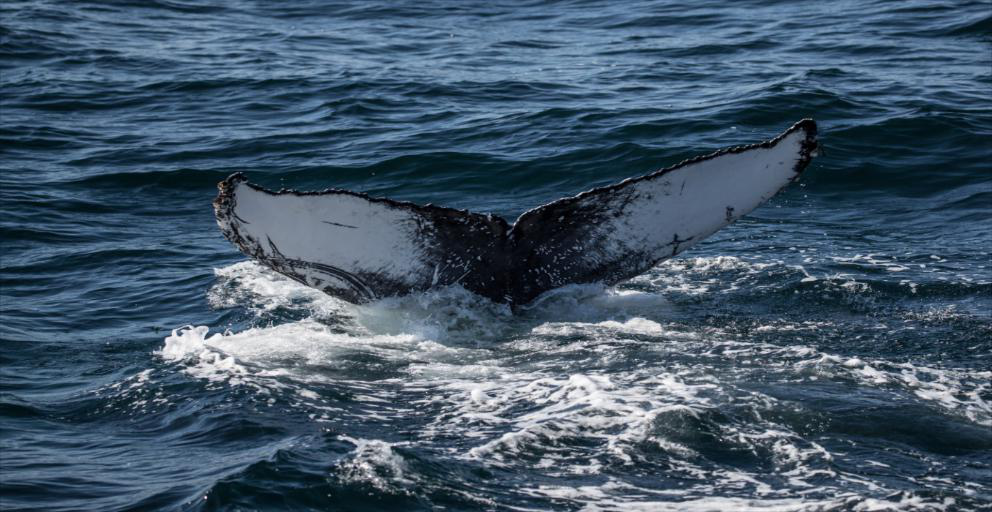

In [4]:
img = load_img('all_reshape/0000e88ab.jpg')
img

In [5]:
img_array = img_to_array(img)
#print(img_array)
print(img_array.shape)
type(img_array)

(512, 992, 3)


numpy.ndarray

In [6]:
imgPath = '/Users/Zeyuan/Documents/Kaggle/humpback-whale-identification/all_reshape'
imglist = os.listdir(imgPath)
print('imgs number:',len(imglist))
print('image shape:',io.imread('all_reshape/%s'%imglist[0]).shape)

imgs number: 25362
image shape: (512, 992)


## 图像预处理
- 图片数量: 25361
- 每张图片（灰度）的大小: (512, 992) 宽992高512 -> 507904
- 需要生成的out_x张量大小: (25361,512,992,1)
- 图片类别向量: y
- 类别数量: num_classes = 5005
- out_y = keras.utils.to_categorical(y, num_classes)

下面这个代码会读取图片(灰度float64模式)，生成一个csv文件all_reshape_gray.csv：每一列是一张图片的一维展开，之后用的时候需要reshape。经过测试，得出了一种保持低内存占用率的写法：程序每次迭代都会重写读写这个csv文件并保存，使得python内部内存不会被重复占用。

In [7]:

print('reading images')
i = 1
#all_reshape_gray = pd.read_csv('all_reshape_gray.csv')
#pixels = np.zeros((1,128*248))
pixels = []
for img_name in sorted(imglist)[1:]: #需要按文件名称顺序排好 排除第一个元素checkpoint  
    
    
    img_gray = io.imread('all_reshape2/%s'%img_name, as_gray=True)
    img_gray_float64 = img_as_float64(img_gray)
    img_gray_1D = np.reshape(img_gray_float64,(1,128*248))
    #all_reshape_gray.loc[ all_reshape_gray.shape[0] ] = img_gray_1D[0]
    pixels.append(img_gray_1D[0])
    print('\rprocessing %d images(%.2f%%), %s images to go.'%(i, (i/25361*100), (25361-i)),end='')
    i+=1
    
#all_reshape_gray.to_csv('all_reshape_gray.csv',index = False)
print('reading finish')

reading images
processing 25361 images(100.00%), 0 images to go.reading finish


In [8]:
pixels = np.array(pixels)

得到pixels二维数组，每一行是一张图片的一维展开。在第一列加入label：

In [9]:
train_df = pd.read_csv('train.csv')
#all_reshape_gray = pd.read_csv('all_reshape_gray.csv')
raw = np.concatenate((train_df[['Id']].values,pixels),axis = 1)

In [23]:
#np.savetxt("all_reshape_gray.txt", raw, delimiter=",")

In [28]:
img_rows, img_cols = 128, 248 
num_classes = 5005

def data_prep(raw): 
    #raw是ndarray，每一行是一张图片的一维展开，第一列是标签
    #输出out_x, out_y
    le = LabelEncoder()
    le.fit(raw[:,0])
    label = le.transform(raw[:,0])
    out_y = keras.utils.to_categorical(label, 5005)
    
    num_images = raw.shape[0]
    x = raw[:,1:]
    out_x = np.reshape(x, (num_images, img_rows, img_cols,1))
    
    #print('raw shape:',raw.shape,
    #      '\ny shape:',raw[:,0].shape,'transform to:',out_y.shape,
    #      '\nx shape:',x.shape,'transform to:',out_x.shape)
    return out_x, out_y

In [29]:
raw_data = raw

x, y = data_prep(raw_data)
print('x shape:',x.shape,'\ny shape:',y.shape)

x shape: (25361, 128, 248, 1) 
y shape: (25361, 5005)
